### Step1 - 导入相关包 & 初始化设置

In [1]:
import os, sys

from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma
# 常用的消息类型
from langchain.messages import HumanMessage, SystemMessage, ToolMessage, AIMessage, AIMessageChunk

from langgraph.checkpoint.memory import InMemorySaver

# 默读取当前目录下的 .env 文件, 可以通过 dotenv_path 来修改
from dotenv import load_dotenv
root_dir = os.path.dirname(os.getcwd())
load_dotenv(dotenv_path=os.path.join(root_dir, ".env"))

# 记录日志
from loguru import logger
logger.remove()
logger.add(sys.stderr, level=os.getenv("LOG_LEVEL"))

1

### Step2 - 加载 & 定义 RAG 相关的工具

In [2]:
# 加载嵌入模型
embed_model = OllamaEmbeddings(
    model=os.getenv("OLLAMA_EMB_MODEL"),
    base_url=os.getenv("OLLAMA_BASE_URL"),
)
embed_model

OllamaEmbeddings(model='qwen3-embedding:4b', validate_model_on_init=False, base_url='http://localhost:11434', client_kwargs={}, async_client_kwargs={}, sync_client_kwargs={}, mirostat=None, mirostat_eta=None, mirostat_tau=None, num_ctx=None, num_gpu=None, keep_alive=None, num_thread=None, repeat_last_n=None, repeat_penalty=None, temperature=None, stop=None, tfs_z=None, top_k=None, top_p=None)

In [3]:
# 加载向量数据库
vector_db = Chroma(
    collection_name="example_collection",
    embedding_function=embed_model,
    persist_directory="./chroma_db",
)
vector_db

In [4]:
# 利用 嵌入模型 和 向量数据库 来构造工具
@tool
def retrieve_context(query: str) -> str:
    """
    retrieve_context 的 Docstring
    
    Args:
    - query: 需要查询的内容
    """
    retrieved_docs = vector_db.similarity_search(query=query, k=2)
    content = ""
    for doc in retrieved_docs:
        content+=(f"Source:{doc.metadata}\nContent:{doc.page_content}\n\n")
    logger.debug(content)
    return content

### Step3 - 创建 Agent 智能体

In [5]:
# 创建 ChatModel: v1 创建聊天模型的方法
chat_model = init_chat_model(
    model_provider="ollama",
    # model 也可以写为 <model_provider>:<model_name> 的形式
    # 这样就可以不用指定 model_provider 这个参数了
    model = os.getenv("OLLAMA_LLM_MODEL"),
    base_url = os.getenv("OLLAMA_BASE_URL"),
    max_tokens = 4096,
)
chat_model

ChatOllama(model='qwen3:4b-instruct', base_url='http://localhost:11434')

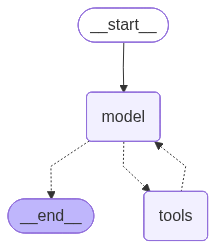

In [6]:
# 创建 Agent
agent = create_agent(
    model=chat_model,
    # 提示词可以不写, 这样也可以在调用时用 SystemMessage 来指定
    system_prompt="你是一个专业的AI助手, 请尽可能结合 retrieve_context 工具的内容来回答问题.",
    # 绑定工具
    tools=[retrieve_context],
)
agent

### Step4 - 调用智能体

In [ ]:
# 方法1: 非流式调用
# 也可以按照如下格式来写: {"messages":[{"role": "user", "content": "<user_question>"}]}
response = agent.invoke({"messages":[HumanMessage("什么是注意力机制?")]})
logger.debug(response)

for msg in response["messages"]:
    msg.pretty_print()

2025-12-07 14:48:24.812 | DEBUG    | __main__:retrieve_context:14 - Source:{'keywords': '', 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) kpathsea version 6.2.2', 'moddate': '2017-12-07T01:03:15+00:00', 'producer': 'pdfTeX-1.40.17', 'trapped': '/False', 'total_pages': 15, 'creator': 'LaTeX with hyperref package', 'title': '', 'page': 0, 'page_label': '1', 'start_index': 0, 'creationdate': '2017-12-07T01:03:15+00:00', 'subject': '', 'author': '', 'source': './1706.03762v5.pdf'}
Content:Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Parmar∗
Google Research
nikip@google.com
Jakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.com
Aidan N. Gomez∗†
University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser ∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗‡
illia.polosukhin@gmail.com
Abstract
The dominant sequence transduction models are b

================================ Human Message =================================

什么是注意力机制?
================================== Ai Message ==================================
Tool Calls:
  retrieve_context (958bd4e9-7063-4fb0-bb13-fa57b2dfbef8)
 Call ID: 958bd4e9-7063-4fb0-bb13-fa57b2dfbef8
  Args:
    query: 什么是注意力机制
================================= Tool Message =================================
Name: retrieve_context

Source:{'keywords': '', 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) kpathsea version 6.2.2', 'moddate': '2017-12-07T01:03:15+00:00', 'producer': 'pdfTeX-1.40.17', 'trapped': '/False', 'total_pages': 15, 'creator': 'LaTeX with hyperref package', 'title': '', 'page': 0, 'page_label': '1', 'start_index': 0, 'creationdate': '2017-12-07T01:03:15+00:00', 'subject': '', 'author': '', 'source': './1706.03762v5.pdf'}
Content:Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com


In [8]:
# 方法2: 流式调用 & stream_mode 为 values
for chunk in agent.stream(
    ({"messages":[HumanMessage("什么是注意力机制?")]}),
    stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

什么是注意力机制?
================================== Ai Message ==================================
Tool Calls:
  retrieve_context (c641c4bf-5541-43cd-8447-9089710c737b)
 Call ID: c641c4bf-5541-43cd-8447-9089710c737b
  Args:
    query: 什么是注意力机制


2025-12-07 14:48:32.853 | DEBUG    | __main__:retrieve_context:14 - Source:{'subject': '', 'total_pages': 15, 'producer': 'pdfTeX-1.40.17', 'page_label': '1', 'keywords': '', 'trapped': '/False', 'author': '', 'source': './1706.03762v5.pdf', 'title': '', 'page': 0, 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) kpathsea version 6.2.2', 'start_index': 0, 'creationdate': '2017-12-07T01:03:15+00:00', 'creator': 'LaTeX with hyperref package', 'moddate': '2017-12-07T01:03:15+00:00'}
Content:Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Parmar∗
Google Research
nikip@google.com
Jakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.com
Aidan N. Gomez∗†
University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser ∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗‡
illia.polosukhin@gmail.com
Abstract
The dominant sequence transduction models are b

================================= Tool Message =================================
Name: retrieve_context

Source:{'subject': '', 'total_pages': 15, 'producer': 'pdfTeX-1.40.17', 'page_label': '1', 'keywords': '', 'trapped': '/False', 'author': '', 'source': './1706.03762v5.pdf', 'title': '', 'page': 0, 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) kpathsea version 6.2.2', 'start_index': 0, 'creationdate': '2017-12-07T01:03:15+00:00', 'creator': 'LaTeX with hyperref package', 'moddate': '2017-12-07T01:03:15+00:00'}
Content:Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Parmar∗
Google Research
nikip@google.com
Jakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.com
Aidan N. Gomez∗†
University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser ∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗‡
illia.polosukhin@gmail.com
Abstract
The domina

In [9]:
# 方法3: 流式调用 & stream_mode 为 messages
for chunk in agent.stream(
    {"messages":[HumanMessage("什么是注意力机制?")]},
    stream_mode="messages"):
    # logger.debug(chunk)
    # ( AIMessageChunk(content='月', additional_kwargs={}, response_metadata={}, id='lc_run--b8d9f214-6fc9-4ba3-8a6b-66471899635c'), 
    # {'langgraph_step': 3, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 
    #  'langgraph_path': ('__pregel_pull', 'model'), 
    #  'langgraph_checkpoint_ns': 'model:7a7be4dc-94fb-6539-aed3-cba6c99c2863', 
    #  'checkpoint_ns': 'model:7a7be4dc-94fb-6539-aed3-cba6c99c2863', 
    #  'ls_provider': 'ollama', 'ls_model_name': 'qwen3:4b-instruct', 'ls_model_type': 'chat', 'ls_temperature': None
    # })
    if isinstance(chunk[0], AIMessageChunk):
        print(chunk[0].content, end="", flush=True)


2025-12-07 14:48:41.228 | DEBUG    | __main__:retrieve_context:14 - Source:{'moddate': '2017-12-07T01:03:15+00:00', 'producer': 'pdfTeX-1.40.17', 'author': '', 'page_label': '1', 'page': 0, 'source': './1706.03762v5.pdf', 'creator': 'LaTeX with hyperref package', 'title': '', 'subject': '', 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) kpathsea version 6.2.2', 'creationdate': '2017-12-07T01:03:15+00:00', 'start_index': 0, 'keywords': '', 'total_pages': 15, 'trapped': '/False'}
Content:Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Parmar∗
Google Research
nikip@google.com
Jakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.com
Aidan N. Gomez∗†
University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser ∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗‡
illia.polosukhin@gmail.com
Abstract
The dominant sequence transduction models are b

注意力机制（Attention Mechanism）是一种在深度学习模型中用于捕捉输入序列中不同部分之间关系的机制。它允许模型在处理一个序列（如句子或时间序列）时，动态地关注输入的不同部分，而不是对所有部分同等对待。

在传统的神经网络模型（如循环神经网络RNN或卷积神经网络CNN）中，信息是通过时间或空间上的逐步传播来处理的，这限制了模型对长距离依赖关系的捕捉能力。而注意力机制通过计算每个输入元素与目标输出之间的相关性，为每个输入元素分配一个“注意力权重”，从而让模型可以“聚焦”在最相关的部分上。

一个典型的例子是“Transformer”模型，它完全基于注意力机制构建，摒弃了传统的循环和卷积结构。在Transformer中，注意力机制被用于两个主要部分：
1. **自注意力（Self-Attention）**：在同一序列内部，每个位置的元素可以关注到序列中的其他位置，从而捕捉到长距离依赖关系。
2. **交叉注意力（Cross-Attention）**：在编码器-解码器结构中，解码器可以关注到编码器输出的特定部分，以生成更准确的输出。

注意力机制的直观理解可以类比为“阅读时的聚焦”：当你阅读一段文字时，你不会同时关注每一个字，而是会根据上下文选择性地关注某些关键词或短语。注意力机制正是通过这种方式，让模型在处理复杂序列时更加高效和准确。

例如，在机器翻译任务中，注意力机制可以帮助模型在翻译一句话时，知道某个英文单词应该对应到哪个中文词语，即使它们在句子中相隔很远。

总之，注意力机制极大地提升了模型对长距离依赖关系的建模能力，是现代自然语言处理（NLP）和深度学习模型的核心组成部分之一。